<a href="https://colab.research.google.com/github/reshalfahsi/3d-viz-score-cam/blob/master/Visualizing_3D_ResNet_Medical_Image_Classification_With_Score_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visualizing 3D ResNet for Medical Image Classification With Score-CAM**

## **Important Libraries**

### **Install**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist k3d
!jupyter nbextension install --py --user k3d
!jupyter nbextension enable --py --user k3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 127.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 316.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 203.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 195.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 320.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 171.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 202.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 117.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

### **Import**

In [ ]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import Accuracy

from scipy.ndimage import interpolation

import os
import cv2
import copy
import warnings

import numpy as np
import matplotlib.pyplot as plt

from numpy import trapz
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from google.colab.patches import cv2_imshow

from medmnist import OrganMNIST3D, INFO

from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex

from google.colab import output
output.enable_custom_widget_manager()

import k3d

k3d.switch_to_text_protocol()

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1629754238


In [ ]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [ ]:
IMG_SIZE                = 64
MAX_EPOCH               = 144
BATCH_SIZE              = 16
EARLY_STOPPING_PATIENCE = 9
LEARNING_RATE           = 1e-2
BASE_LR_SCALE           = 2e-3

## **Dataset**

### **Utils**

In [ ]:
try:
    INFO = INFO[OrganMNIST3D.flag]
except:
    pass

### **Load**

In [ ]:
TrainDataset = OrganMNIST3D(
    split="train",
    as_rgb=True,
    download=True,
    size=IMG_SIZE,
    root=f'{EXPERIMENT_DIR}dataset',
)
ValDataset = OrganMNIST3D(
    split="val",
    as_rgb=True,
    download=True,
    size=IMG_SIZE,
    root=f'{EXPERIMENT_DIR}dataset',
)
TestDataset = OrganMNIST3D(
    split="test",
    as_rgb=True,
    download=True,
    size=IMG_SIZE,
    root=f'{EXPERIMENT_DIR}dataset',
)

100%|██████████| 361470105/361470105 [00:19<00:00, 18122122.94it/s]


Using downloaded and verified file: experiment/dataset/organmnist3d_64.npz
Using downloaded and verified file: experiment/dataset/organmnist3d_64.npz


## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Module**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(
            inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            planes, planes * self.expansion, kernel_size=3, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm3d(planes * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv3d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm3d(self.expansion * planes),
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv3d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.inplanes, planes, strides[i]))
            self.inplanes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### **Wrapper**

In [ ]:
class ResNet3D(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.lr = LEARNING_RATE
        self.max_epoch = MAX_EPOCH
        self.lr_now = self.lr * 1e3

        self.arch = ResNet(
            BasicBlock,
            [2, 2, 2, 2],
            num_classes=len(INFO['label']),
        )

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=len(INFO['label']),
        )
        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=len(INFO['label']),
        )
        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=len(INFO['label']),
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        x = x.float()
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)

        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        sch = self.lr_schedulers()
        sch.step()

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = f"experiment/training/{MODEL_NAME}_acc_plot.png"
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            TestDataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CyclicLR(
                optimizer,
                base_lr=BASE_LR_SCALE * self.lr,
                max_lr=self.lr,
                cycle_momentum=False,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL_NAME = ResNet3D.__name__
MODEL = ResNet3D
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 1629754238
INFO:lightning.fabric.utilities.seed:Seed set to 1629754238


ResNet3D


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params
------------------------------------------------------
0 | arch           | ResNet             | 33.2 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
33.2 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00032438999999999976 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0006287799999999996 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0009331699999999993 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.001237559999999999 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0015419499999999987 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0018463399999999986 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0021507299999999983 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.002455119999999998 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0027595100000000023 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0030639000000000018 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0033682900000000016 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0036726800000000015 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.003977070000000001 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.004281460000000001 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.004585850000000001 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0048902400000000006 - Epoch: 15


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00519463 - Epoch: 16


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00549902 - Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.005803409999999999 - Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.006107799999999999 - Epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.006412189999999999 - Epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.006716580000000003 - Epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007020970000000003 - Epoch: 22


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007325360000000003 - Epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007629750000000003 - Epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007934140000000001 - Epoch: 25


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00823853 - Epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00854292 - Epoch: 27


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00884731 - Epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0091517 - Epoch: 29


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00945609 - Epoch: 30


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00976048 - Epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00993513 - Epoch: 32


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00963074 - Epoch: 33


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00932635 - Epoch: 34


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00902196 - Epoch: 35


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.008717570000000001 - Epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.008413180000000003 - Epoch: 37


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.008108790000000003 - Epoch: 38


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007804400000000003 - Epoch: 39


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007500010000000004 - Epoch: 40


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007195620000000004 - Epoch: 41


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00689123 - Epoch: 42


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00658684 - Epoch: 43


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00628245 - Epoch: 44


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00597806 - Epoch: 45


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0056736700000000004 - Epoch: 46


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.005369280000000001 - Epoch: 47


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.005064890000000002 - Epoch: 48


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.004760500000000002 - Epoch: 49


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0044561099999999975 - Epoch: 50


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.004151719999999998 - Epoch: 51


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0038473299999999978 - Epoch: 52


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.003542939999999998 - Epoch: 53


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0032385499999999985 - Epoch: 54


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0029341599999999986 - Epoch: 55


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0026297699999999987 - Epoch: 56


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.002325379999999999 - Epoch: 57


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0020209899999999994 - Epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0017165999999999995 - Epoch: 59


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0014122099999999997 - Epoch: 60


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00110782 - Epoch: 61


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0008034300000000003 - Epoch: 62


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0004990400000000005 - Epoch: 63


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00019465000000000072 - Epoch: 64


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.000149739999999999 - Epoch: 65


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.00045412999999999877 - Epoch: 66


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0007585199999999985 - Epoch: 67


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0010629099999999983 - Epoch: 68


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0013672999999999982 - Epoch: 69


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0016716899999999978 - Epoch: 70


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0019760799999999977 - Epoch: 71


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.002280469999999997 - Epoch: 72


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.002584859999999997 - Epoch: 73


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.002889249999999997 - Epoch: 74


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0031936399999999967 - Epoch: 75


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.003498029999999996 - Epoch: 76


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.003802419999999996 - Epoch: 77


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.0041068099999999955 - Epoch: 78


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.004411199999999995 - Epoch: 79


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.004715589999999995 - Epoch: 80


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.005019979999999995 - Epoch: 81


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.005324369999999995 - Epoch: 82


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.005628759999999995 - Epoch: 83


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.005933149999999995 - Epoch: 84


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.006237540000000003 - Epoch: 85


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.006541930000000002 - Epoch: 86


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.006846320000000002 - Epoch: 87


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007150710000000002 - Epoch: 88


Validation: |          | 0/? [00:00<?, ?it/s]

[ResNet3D] Learning Rate Changed: 0.007455100000000002 - Epoch: 89


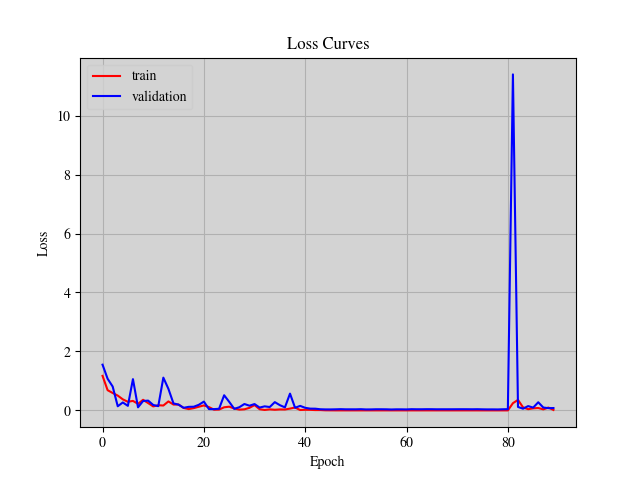

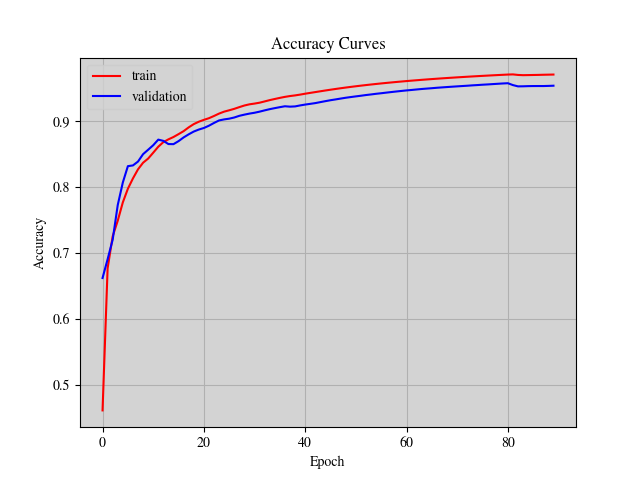

<Figure size 640x480 with 0 Axes>

In [ ]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = MODEL()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=EARLY_STOPPING_PATIENCE,
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [ ]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/ResNet3D_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/ResNet3D_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/ResNet3D_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8979705572128296     │
│         test_loss         │    0.5702451467514038     │
└───────────────────────────┴───────────────────────────┘

## **Visualization**

### **Score-CAM**

In [ ]:
class CAMExtractor(object):
    """
        Extracts CAM features from the model
    """
    def forward(self, x, stage):
        raise NotImplementedError

    def __call__(self, x, class_index, stage):
        return self.extract(x, class_index, stage)

    def extract(self, x, class_index, stage):
        raise NotImplementedError

In [ ]:
class ScoreCAMResNet3D(CAMExtractor):
    def __init__(self, model):
        super(ScoreCAMResNet3D, self).__init__()
        self.model = model
        self.model.eval()
        if torch.cuda.is_available():
            self.model.cuda()
        self.activation = None
        self.__allowed_feat = [
            'layer1',
            'layer2',
            'layer3',
            'layer4',
        ]

    def forward(self, x, stage):
        assert stage in self.__allowed_feat

        out = self.model.relu(
            self.model.bn1(
                self.model.conv1(x)
            )
        )
        out = self.model.maxpool(out)

        out = self.model.layer1(out)
        if stage == 'layer1':
            self.activation = out.detach()
        out = self.model.layer2(out)
        if stage == 'layer2':
            self.activation = out.detach()
        out = self.model.layer3(out)
        if stage == 'layer3':
            self.activation = out.detach()
        out = self.model.layer4(out)
        if stage == 'layer4':
            self.activation = out.detach()

        out = self.model.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.model.fc(out)
        return out

    def extract(self, x, class_index, stage):
        assert x.shape[0] == 1

        if torch.cuda.is_available():
            x = x.cuda()

        _ = self.forward(x, stage)

        score_saliency_map = torch.zeros(
            (1, 1, x.shape[-3], x.shape[-2], x.shape[-1])
        )

        if torch.cuda.is_available():
            self.activation = self.activation.cuda()
            score_saliency_map = score_saliency_map.cuda()

        with torch.no_grad():
            for channel in range(self.activation.shape[1]):
                # upsampling
                saliency_map = F.interpolate(
                    torch.unsqueeze(
                        self.activation[:, channel, :, :, :], 1
                    ),
                    size=(x.shape[-3], x.shape[-2], x.shape[-1]),
                    mode='trilinear',
                    align_corners=False,
                )

                if saliency_map.max() == saliency_map.min():
                    continue

                # normalize to 0-1
                norm_saliency_map = (
                    saliency_map - saliency_map.min()
                ) / (saliency_map.max() - saliency_map.min())

                output = F.softmax(self.model(x * norm_saliency_map), -1)

                score_saliency_map +=  output[
                    :, class_index.item()
                ].mean() * saliency_map

        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min = score_saliency_map.min()
        score_saliency_map_max = score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(
            score_saliency_map_max - score_saliency_map_min
        ).data.cpu().numpy()

        return score_saliency_map

### **Initialize**

In [ ]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH).arch
model.eval()

cam_model = ScoreCAMResNet3D(model)

VizLoader = data.DataLoader(
    TestDataset,
    batch_size=1,
    shuffle=False,
)

In [ ]:
SLICE_STRIDE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DAUC = list()
IAUC = list()

### **Evaluate**

In [ ]:
sample_idx = 0

for batch in tqdm(VizLoader):
    image, category = batch

    image = image.view(1, 3, IMG_SIZE, IMG_SIZE, IMG_SIZE).float()

    cam_mask = cam_model(image, category.view(category.shape[0]), "layer4")

    # Evaluation
    DHW = cam_mask.shape[-3] * cam_mask.shape[-2] * cam_mask.shape[-1]
    STEP = SLICE_STRIDE * cam_mask.shape[-3]
    N_STEP = (DHW + STEP - 1) // STEP

    CLASS_NAME = INFO["label"][str(category.detach().cpu().item())]

    salient_order = np.flip(np.argsort(cam_mask.reshape(-1), axis=0), axis=-1)

    ## Deletion Area Under the Curve (DAUC)
    start = copy.deepcopy(image)
    finish = torch.zeros_like(start)

    scores = np.empty(N_STEP + 1)

    DAUC_ACC = Accuracy(task="multiclass", num_classes=len(INFO["label"]))
    pred = model(start.to(DEVICE))
    DAUC_ACC.update(pred.softmax(1).cpu(), category.view(category.shape[0]).cpu())
    HIGHEST_ACC = DAUC_ACC.compute().data.detach().cpu()

    for idx in range(N_STEP + 1):
        DAUC_ACC = Accuracy(task="multiclass", num_classes=len(INFO["label"]))
        pred = model(start.to(DEVICE))
        DAUC_ACC.update(pred.softmax(1).cpu(), category.view(category.shape[0]).cpu())
        scores[idx] = np.clip(
            DAUC_ACC.compute().data.detach().cpu() / HIGHEST_ACC, 0.0, 1.0
        )

        if idx < N_STEP:
            coords = salient_order[STEP * idx : STEP * (idx + 1)]

            # this step is crucial
            # moving the gpu tensor to the cpu tensor, mixing both is discouraged
            start = start.cpu()

            start.cpu().numpy().reshape(1, 3, DHW)[:, :, coords] = (
                finish.data.detach()
                .cpu()
                .numpy()
                .reshape(1, 3, DHW)[:, :, coords]
                .copy()
            )

            delete_sum = (
                finish.data.detach()
                .cpu()
                .numpy()
                .reshape(1, 3, DHW)[:, :, coords]
                .copy()
                .sum()
            )

            if delete_sum > 0.:
                assert (
                    start.cpu().numpy().reshape(1, 3, DHW)[:, :, coords].sum() == 0
                ), "Failed to delete voxels"
        else:
            if start.sum() != 0:
                raise ValueError("not all voxels are deleted")

            plt.plot(np.arange(idx + 1) / N_STEP, scores[: idx + 1])
            plt.xlim(-0.1, 1.1)
            plt.ylim(0, 1.05)
            plt.fill_between(
                np.arange(idx + 1) / N_STEP, 0, scores[: idx + 1], alpha=0.4
            )
            dauc_score = trapz(scores, dx=1 / (N_STEP + 1))
            plt.title(
                f"DAUC Plot of {MODEL_NAME}_{str(sample_idx).zfill(4)}_{CLASS_NAME}'\n' with the score of {dauc_score}"
            )
            plt.xlabel("Voxel Deleted")
            plt.ylabel("Accuracy")
            os.makedirs(f"{EXPERIMENT_DIR}DAUC", exist_ok=True)
            plt.savefig(f"{EXPERIMENT_DIR}DAUC/dauc_{MODEL_NAME}_{str(sample_idx).zfill(4)}.png")
            plt.close()
            DAUC.append(dauc_score)

    ## Insertion Area Under the Curve (IAUC)
    finish = copy.deepcopy(image)
    start = torch.zeros_like(finish)

    scores = np.empty(N_STEP + 1)

    IAUC_ACC = Accuracy(task="multiclass", num_classes=len(INFO["label"]))
    pred = model(finish.to(DEVICE))
    IAUC_ACC.update(pred.softmax(1).cpu(), category.view(category.shape[0]).cpu())
    HIGHEST_ACC = IAUC_ACC.compute().data.detach().cpu()

    for idx in range(N_STEP + 1):
        IAUC_ACC = Accuracy(task="multiclass", num_classes=len(INFO["label"]))
        pred = model(start.to(DEVICE))
        IAUC_ACC.update(pred.softmax(1).cpu(), category.view(category.shape[0]).cpu())
        scores[idx] = np.clip(
            IAUC_ACC.compute().data.detach().cpu() / HIGHEST_ACC, 0.0, 1.0
        )

        if idx < N_STEP:
            coords = salient_order[STEP * idx : STEP * (idx + 1)]

            # this step is crucial
            # moving the gpu tensor to the cpu tensor, mixing both is discouraged
            start = start.cpu()

            start.cpu().numpy().reshape(1, 3, DHW)[:, :, coords] = (
                finish.data.detach()
                .cpu()
                .numpy()
                .reshape(1, 3, DHW)[:, :, coords]
                .copy()
            )

            insert_sum = (
                finish.data.detach()
                .cpu()
                .numpy()
                .reshape(1, 3, DHW)[:, :, coords]
                .copy()
                .sum()
            )

            if insert_sum > 0.:
                assert (
                    start.cpu().numpy().reshape(1, 3, DHW)[:, :, coords].sum() != 0
                ), "Failed to insert voxels"
        else:
            if start.sum() == 0:
                raise ValueError("no voxels were inserted")

            plt.plot(np.arange(idx + 1) / N_STEP, scores[: idx + 1])
            plt.xlim(-0.1, 1.1)
            plt.ylim(0, 1.05)
            plt.fill_between(
                np.arange(idx + 1) / N_STEP, 0, scores[: idx + 1], alpha=0.4
            )
            iauc_score = trapz(scores, dx=1 / (N_STEP + 1))
            plt.title(
                f"IAUC Plot of {MODEL_NAME}_{str(sample_idx).zfill(4)}_{CLASS_NAME}'\n' with the score of {iauc_score}"
            )
            plt.xlabel("Voxel Inserted")
            plt.ylabel("Accuracy")
            os.makedirs(f"{EXPERIMENT_DIR}IAUC", exist_ok=True)
            plt.savefig(f"{EXPERIMENT_DIR}IAUC/iauc_{MODEL_NAME}_{str(sample_idx).zfill(4)}.png")
            plt.close()
            IAUC.append(iauc_score)

    ### 3D Visualization
    plot = k3d.plot()

    plot.display()
    plot.close()

    organ = torch.zeros_like(image)
    organ_colormap = list()
    for color in range(128, 256, 1):
        organ[(image * 255).int() == color] = color
        organ_colormap.append(
            int(f"0x{str(rgb2hex((color / 255., color / 255., color / 255.)))[1:]}", 16)
        )
    organ = organ[0, 0]
    organ = (organ.detach().cpu().numpy()).astype(np.uint8)

    plt_organ = k3d.voxels(
        organ,
        color_map=organ_colormap[::-1],
        opacity=0.025,
        compression_level=9,
        name=" ".join(CLASS_NAME.split("-")[::-1]).title(),
    )

    cam_mask = (cam_mask * 255).astype(np.uint8)
    cam_mask = cam_mask[0, 0]

    color_map_jet_raw = get_cmap("jet", len(np.unique(cam_mask)))
    color_map_jet = list()
    for c in range(color_map_jet_raw.N):
        rgba = color_map_jet_raw(c)
        hex_string = f"0x{str(rgb2hex(rgba))[1:]}"
        hex_value = int(hex_string, 16)
        color_map_jet.append(hex_value)

    cam_mask[organ == 0] = 0

    plt_cam_mask = k3d.voxels(
        cam_mask,
        color_map=color_map_jet[1:],
        opacity=0.075,
        compression_level=9,
        name="Score-CAM Mask",
    )

    plot += plt_organ
    plot += plt_cam_mask

    os.makedirs(f"{EXPERIMENT_DIR}3D_Interactive/", exist_ok=True)

    with open(
        f"{EXPERIMENT_DIR}3D_Interactive/plot_{str(sample_idx).zfill(4)}.html",
        "w",
    ) as fp:
        fp.write(plot.get_snapshot())

    del plot, plt_organ, plt_cam_mask
    sample_idx += 1

print(f"Overall DAUC: {np.nanmean(np.array(DAUC))}±{np.nanstd(np.array(DAUC))}")
print(f"Overall IAUC: {np.nanmean(np.array(IAUC))}±{np.nanstd(np.array(IAUC))}")

  0%|          | 0/610 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Overall DAUC: 0.2575990327857194±0.17103598703706835
Overall IAUC: 0.6750231135765593±0.19443347656148807


In [ ]:
!zip -r 3D_Interactive.zip experiment/3D_Interactive
!zip -r IAUC.zip experiment/IAUC
!zip -r DAUC.zip experiment/DAUC

  adding: experiment/3D_Interactive/ (stored 0%)
  adding: experiment/3D_Interactive/plot_0488.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0421.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0600.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0193.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0121.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0259.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0164.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0103.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0187.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0589.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0195.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0109.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0523.html (deflated 26%)
  adding: experiment/3D_Interactive/plot_0025.html (deflated 26%)
  adding: experiment/3D_Int